In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, f1_score  # Added f1_score import
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 🔄 Chargement des données
df = pd.read_csv("kiali_kpi_metrics.csv")

# 🧽 Nettoyage de time_window
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()

if df.empty:
    raise ValueError("🚨 Aucun enregistrement avec time_window == '15s'. Vérifiez le fichier CSV.")

# ✅ Nettoyage des colonnes numériques
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)

# 🏷️ Attribution du statut
def assign_status(er):
    if er < 0.01:
        return 0
    elif er < 0.1:
        return 1
    else:
        return 2

def assign_status(er):
    if er < 0.15:
        return 0
    
    else:
        return 1



df['status'] = df['error_rate'].apply(assign_status)
df.drop(df[df['istio_request_bytes'] == 0.0].index, inplace = True)
df.drop(df[df['new_request'] < 0.0].index, inplace = True)
df = df.dropna(subset=["request_rate"])
df.to_csv("data2.csv", index=False)







class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target
        
    def __len__(self):
        return 1  # We'll treat the whole dataset as one graph
    
    def __getitem__(self, idx):
        edge_index = []
        edge_attr = []
        edge_labels = []
        
        # Create edges with features and labels
        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        # Create node features (using random features since we don't have node features)
        num_nodes = len(self.node_map)
        x = torch.randn((num_nodes, 16))  # 16-dimensional random features
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, data):
        # Node embeddings
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        
        # Edge prediction
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        
        # Combine node embeddings and edge features
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

def train():
    # Load and preprocess data
    df = pd.read_csv('data2.csv')
    

    df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9  # Convert to seconds


    # Prepare features and target
    features = ['throughput', 'duration_milliseconds', 'request_rate','istio_request_bytes','average_latency','istio_request_bytes','new_request','timestamp']  # Excluding error_rate
    target = 'status'
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    #df[features] = StandardScaler().fit_transform(df[features])
    
    # Create node mapping
    all_nodes = sorted(list(set(df['source_workload'].unique()).union(set(df['destination_workload'].unique()))))
    node_map = {node: i for i, node in enumerate(all_nodes)}
    
    # Create dataset
    dataset = MicroserviceDataset(df, node_map, features, target)
    
    # Since we have one graph, we'll use a single DataLoader with batch_size=1
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Initialize model
    model = EdgePredictorGNN(
        node_features=16,  # Matches our random node features
        edge_features=len(features),
        hidden_dim=64,
        num_classes=2  # healthy, degraded, error
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print training stats
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d} | Loss: {total_loss/len(loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        data = dataset[0].to(device)
        out = model(data)
        pred = out.argmax(dim=1).cpu().numpy()
        truth = data.y.cpu().numpy()
        
        print("\nClassification Report:")
        print(classification_report(truth, pred, target_names=['healthy', 'degraded']))
        print("Macro F1-score:", f1_score(truth, pred, average='macro'))

if __name__ == "__main__":
    train()

C:\Users\marti\AppData\Local\Temp\ipykernel_16636\1763659225.py:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


Epoch 010 | Loss: 0.2855
Epoch 020 | Loss: 0.1431
Epoch 030 | Loss: 0.3453
Epoch 040 | Loss: 0.3391
Epoch 050 | Loss: 0.1072
Epoch 060 | Loss: 0.1351
Epoch 070 | Loss: 0.1841
Epoch 080 | Loss: 0.2954
Epoch 090 | Loss: 0.2028
Epoch 100 | Loss: 0.2060

Classification Report:
              precision    recall  f1-score   support

     healthy       0.98      1.00      0.99       357
    degraded       0.96      0.74      0.84        31

    accuracy                           0.98       388
   macro avg       0.97      0.87      0.91       388
weighted avg       0.98      0.98      0.98       388

Macro F1-score: 0.9119404866977683


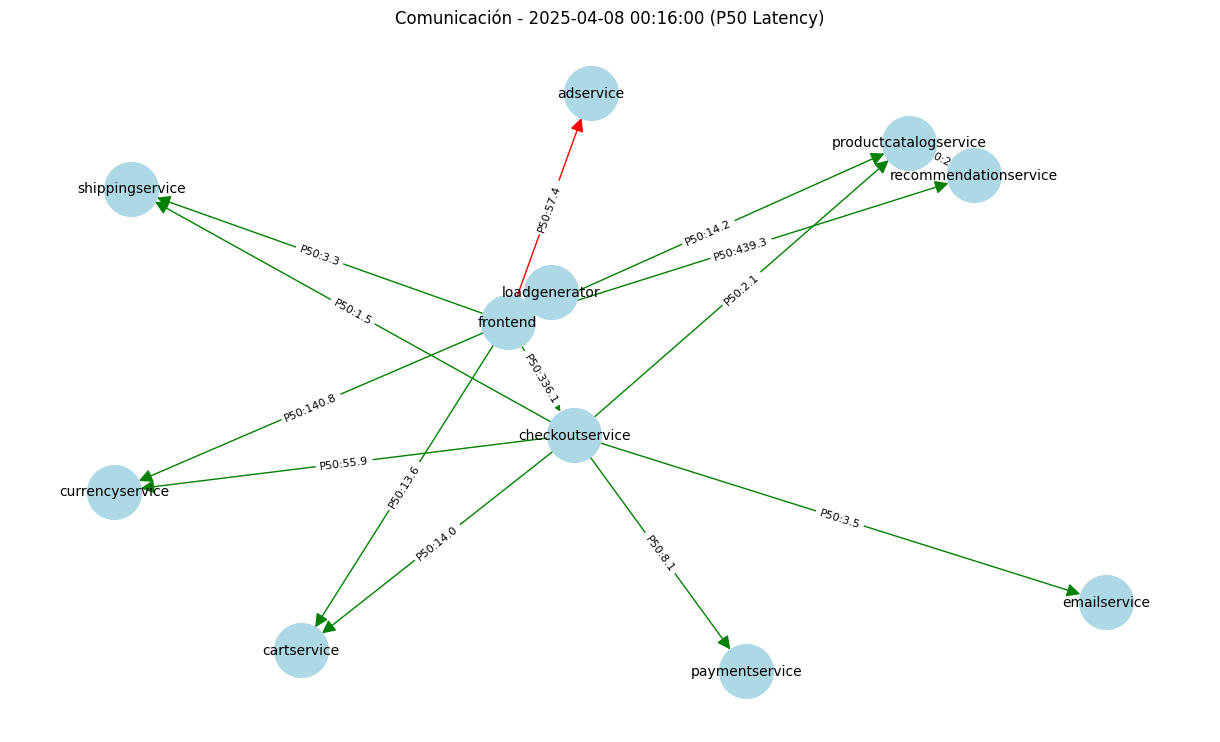

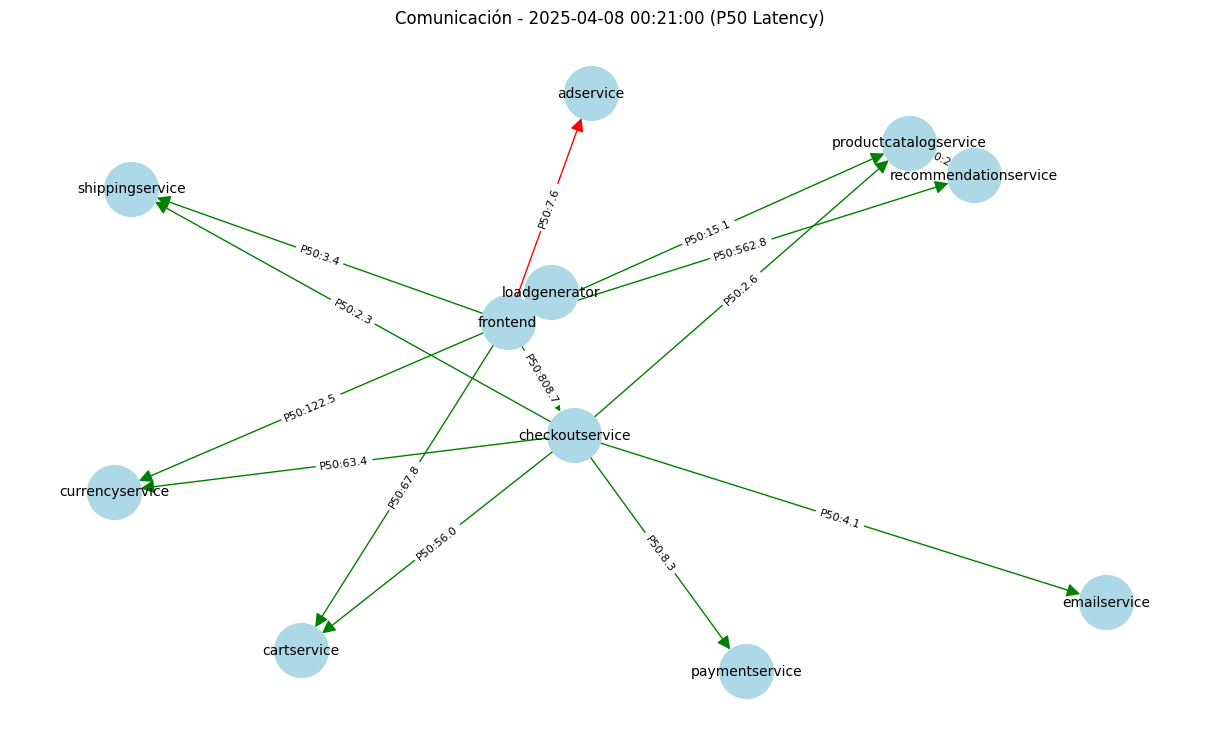

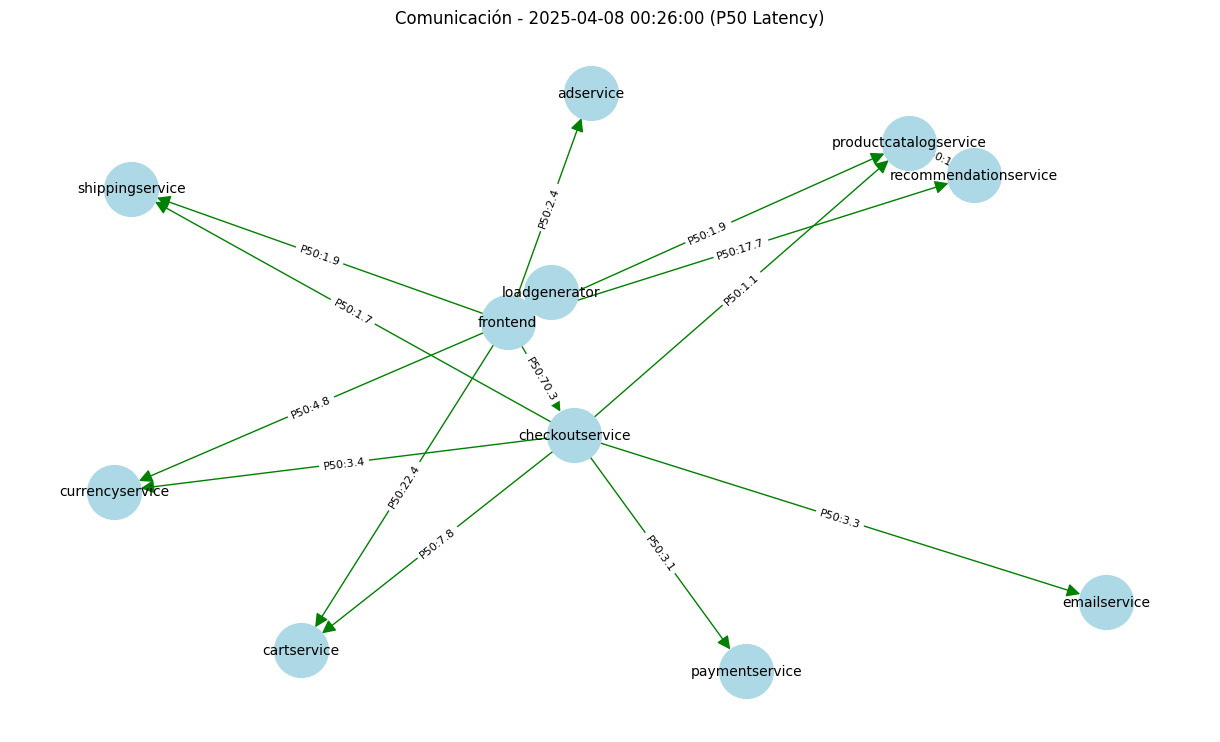

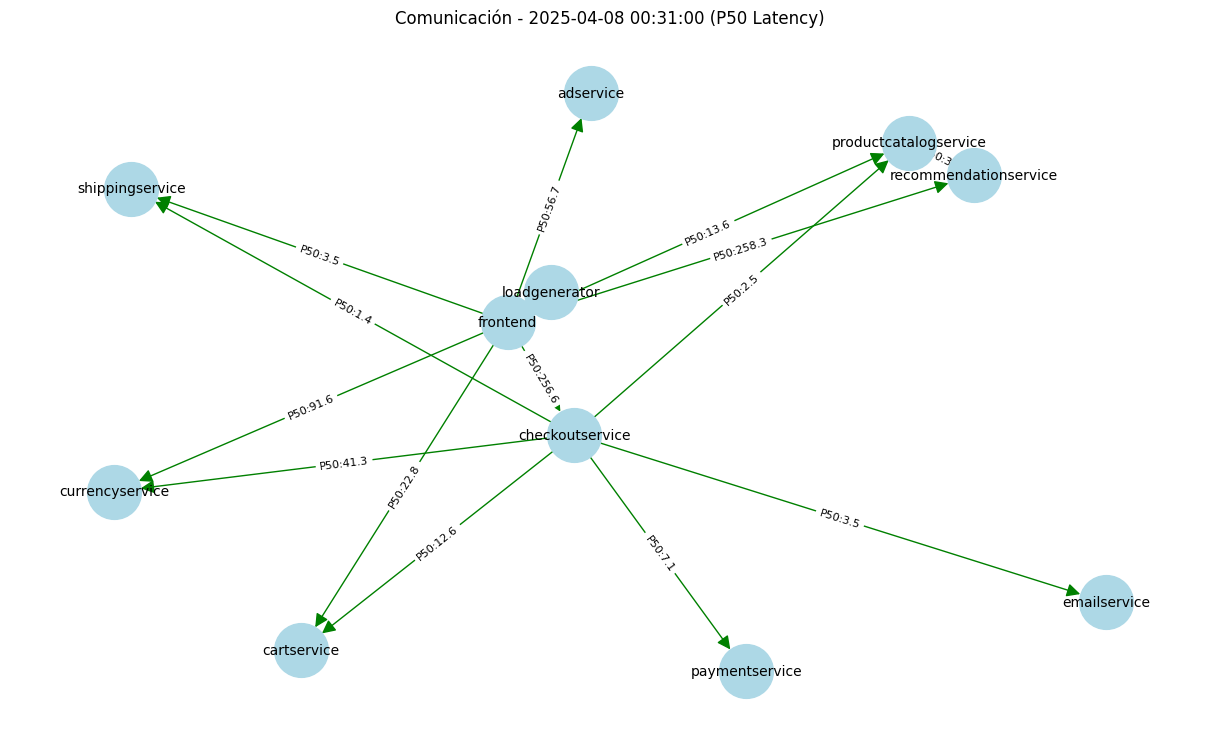

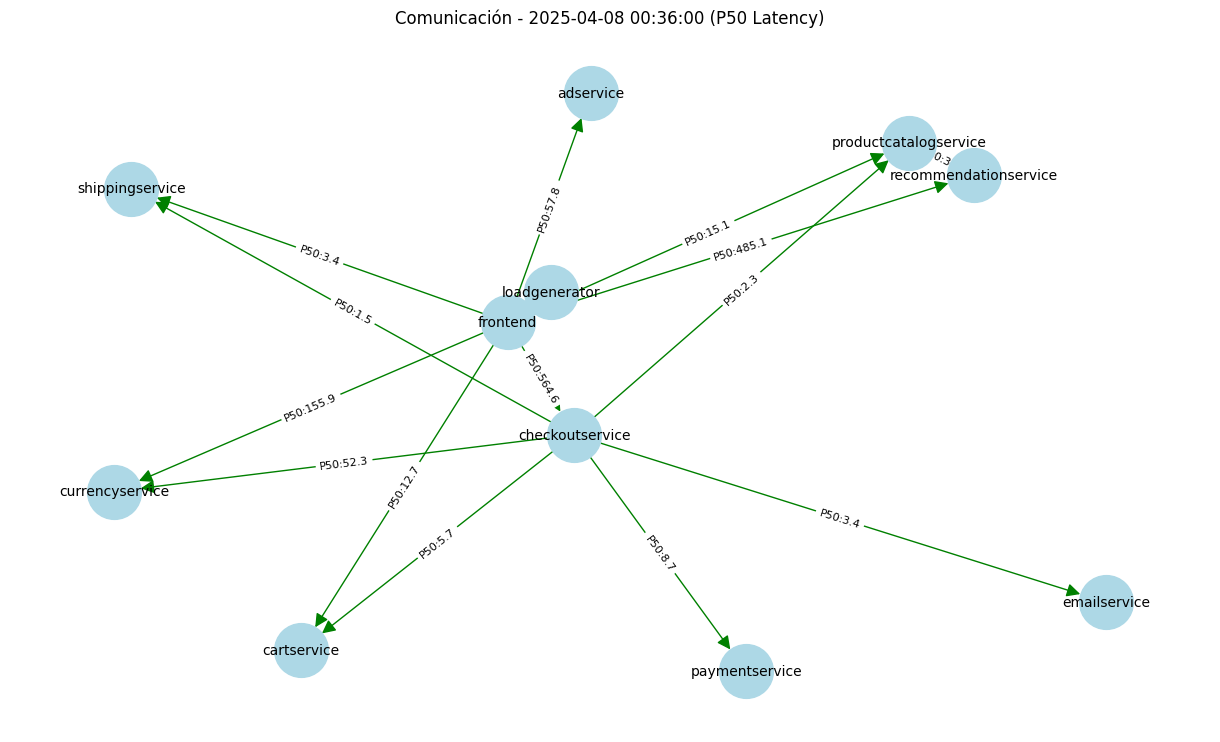

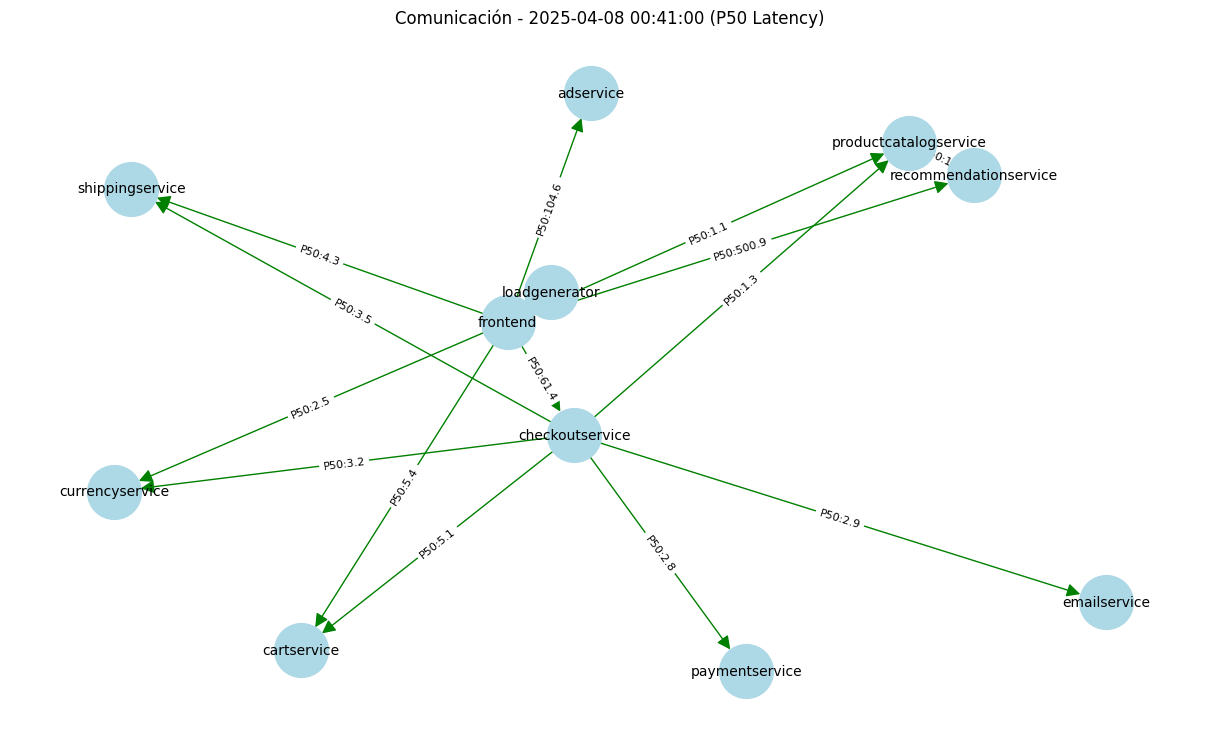

In [2]:
##P50 Latency Visualization


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar los datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# 🕒 Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Unir datasets
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🎯 Asignar estado
def assign_status(er):
    return 0 if er < 0.15 else 1
df['status'] = df['error_rate_kpi'].apply(assign_status)

# 📆 Obtener momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# 📊 Visualización temporal con métricas
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   p50=row.get("p50_latency", None),
                   p90=row.get("p90_latency", None),
                   p99=row.get("p99_latency", None))

    edge_colors = ['green' if G[u][v]['status'] == 0 else 'red' for u, v in G.edges()]
    edge_labels = { (u, v): f"P50:{G[u][v]['p50']:.1f}" for u, v in G.edges() if G[u][v]['p50'] is not None }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors,
            node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} (P50 Latency)")
    plt.show()


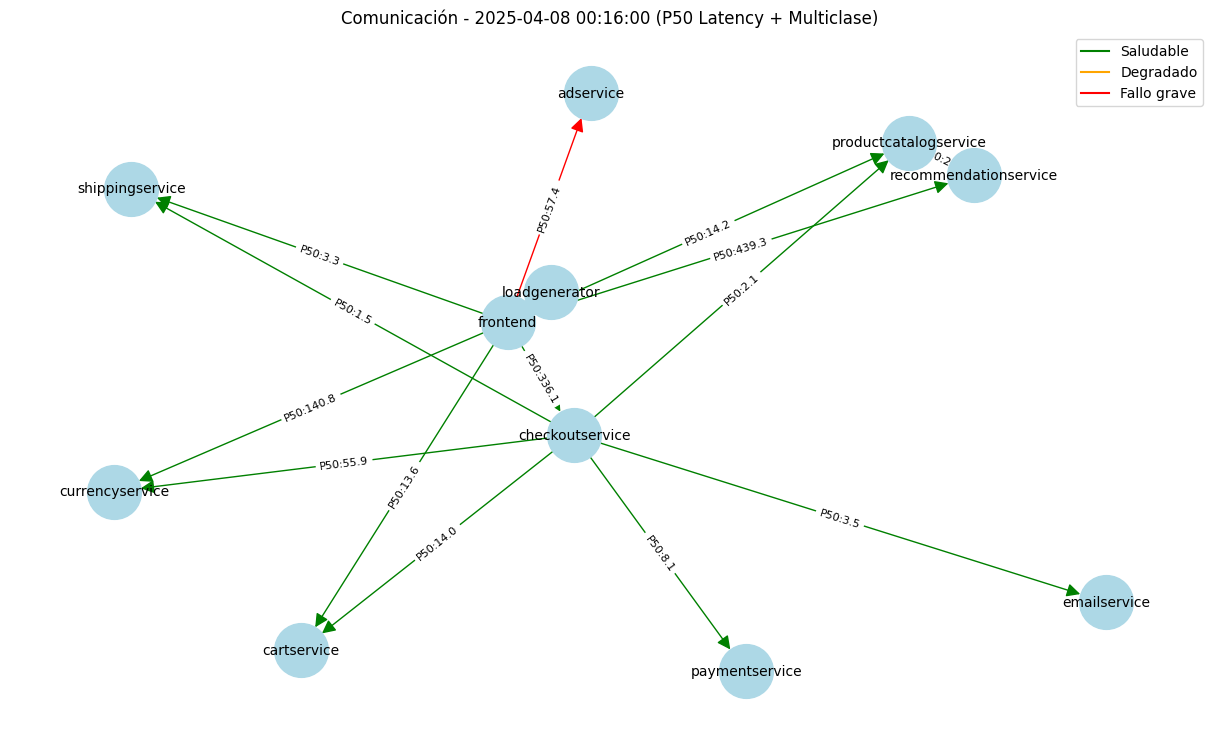

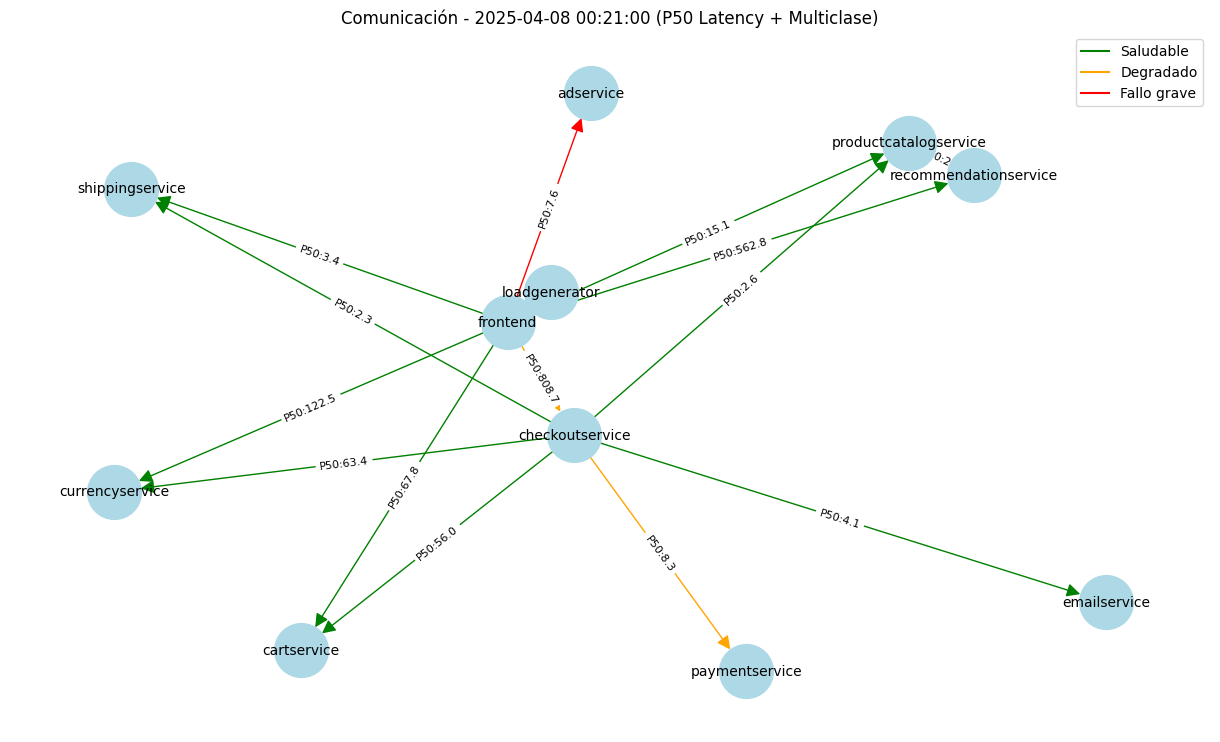

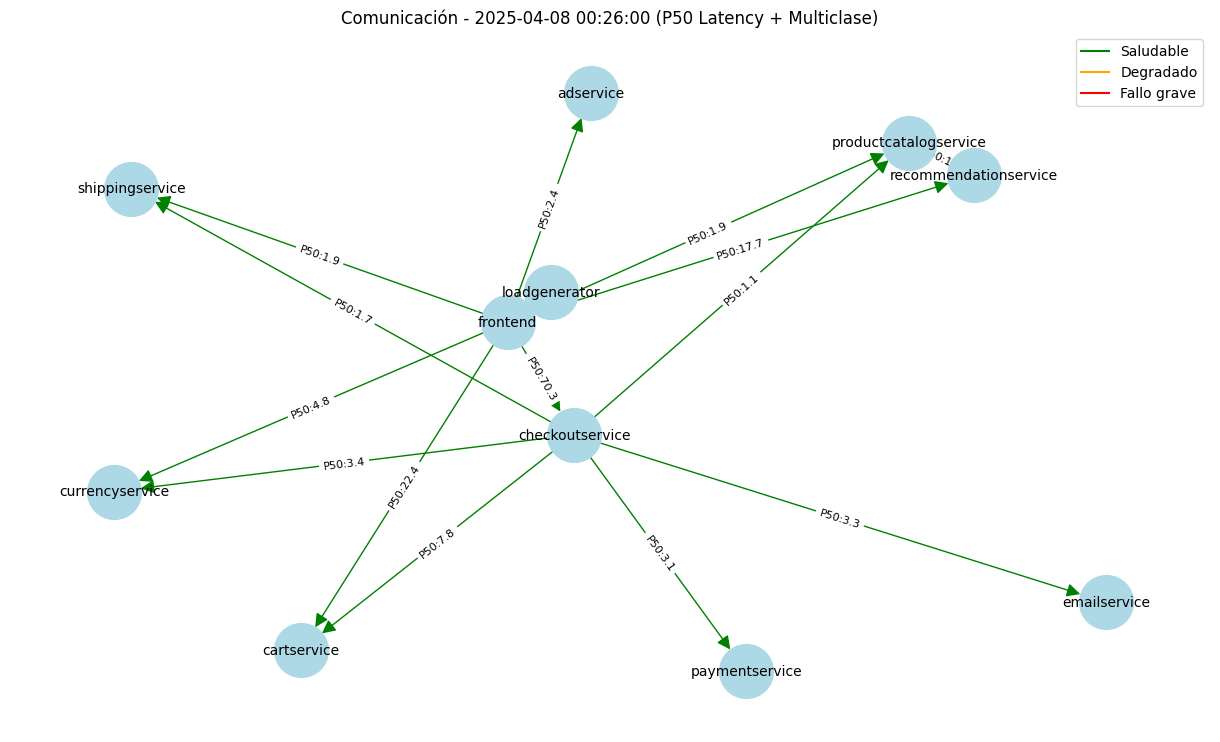

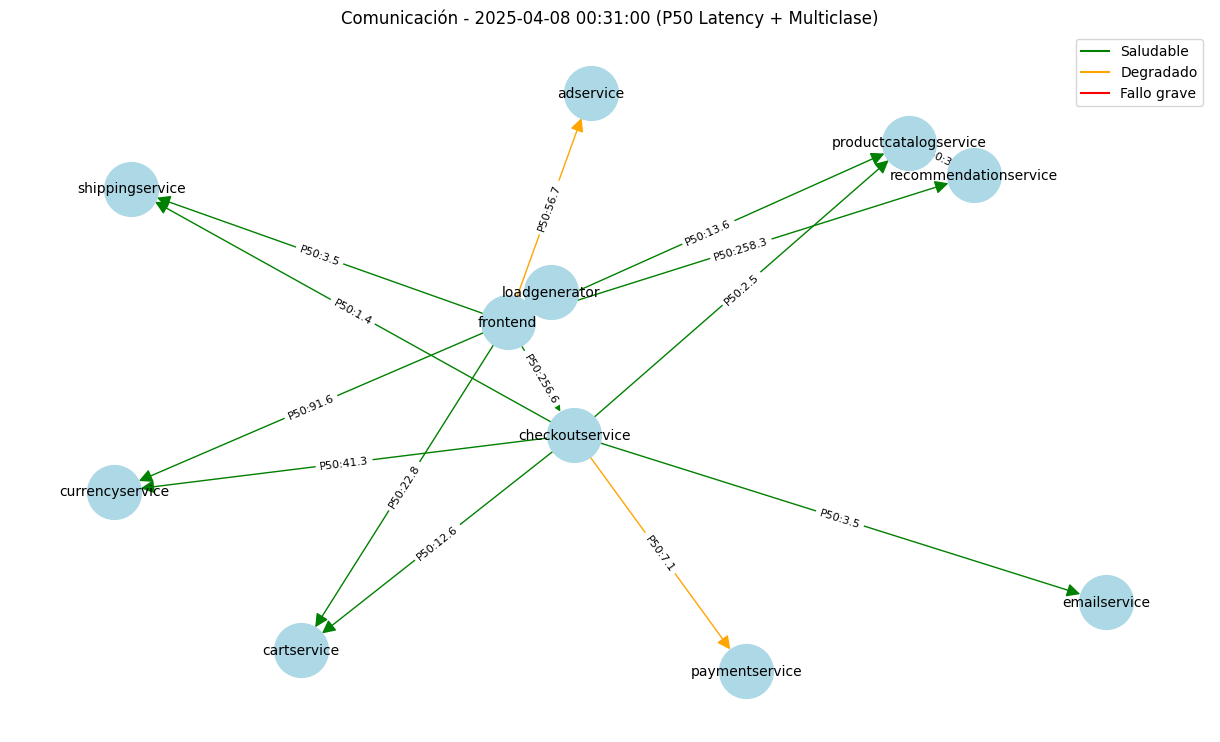

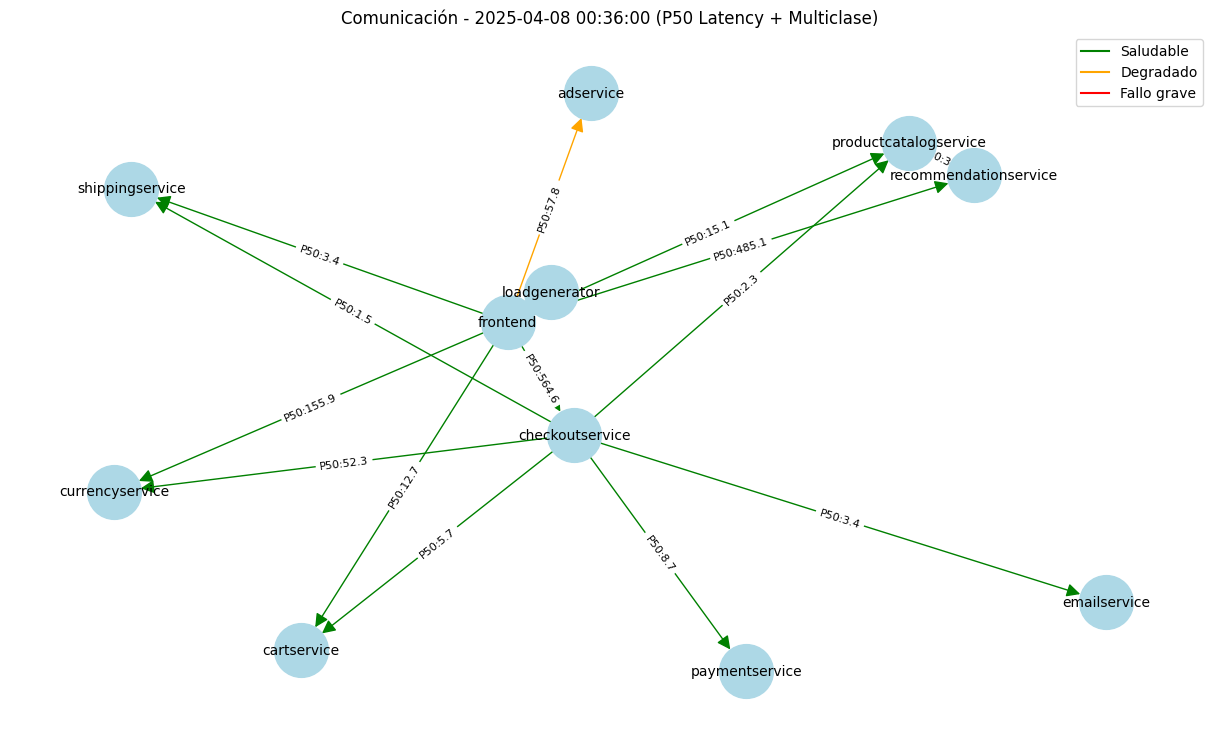

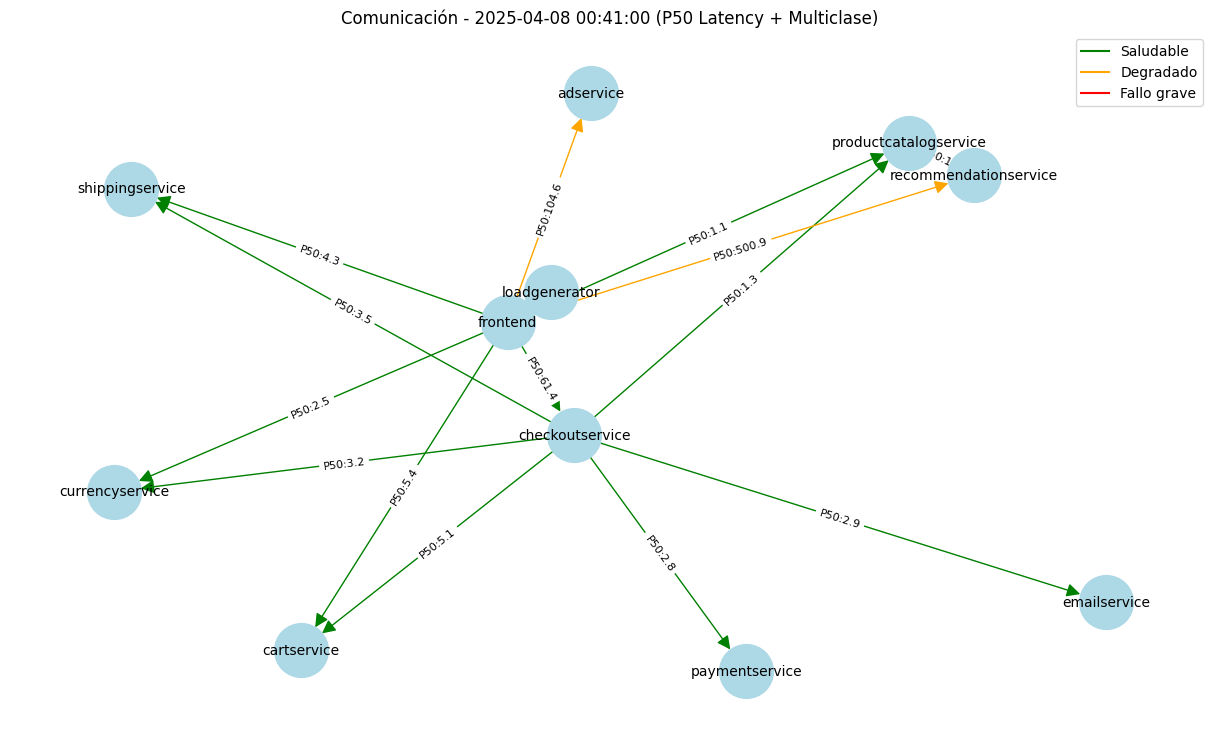

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# ⏱ Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Merge datasets
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🏷 Clasificación multiclase
def assign_status_multiclase(er):
    if er < 0.01:
        return 0  # Saludable
    elif er < 0.15:
        return 1  # Degradado
    else:
        return 2  # Fallo grave

df['status'] = df['error_rate_kpi'].apply(assign_status_multiclase)

# 📆 Momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# 🎨 Mapeo de colores por clase
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Fallo grave"}

# 📊 Visualización temporal
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   p50=row.get("p50_latency", None))

    edge_colors = [color_map.get(G[u][v]['status'], 'gray') for u, v in G.edges()]
    edge_labels = { (u, v): f"P50:{G[u][v]['p50']:.1f}" for u, v in G.edges() if G[u][v]['p50'] is not None }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color=edge_colors, node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Añadir leyenda personalizada
    for cls, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[cls])
    plt.legend(loc="upper right")

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} (P50 Latency + Multiclase)")
    plt.show()


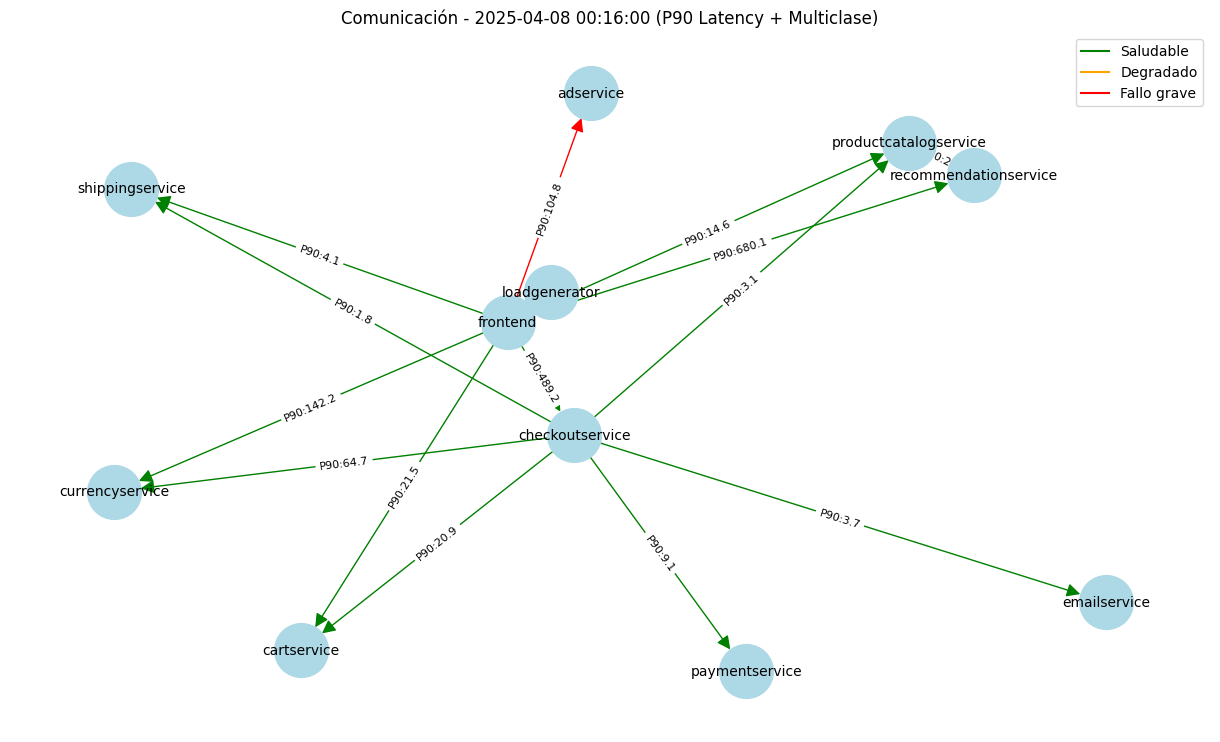

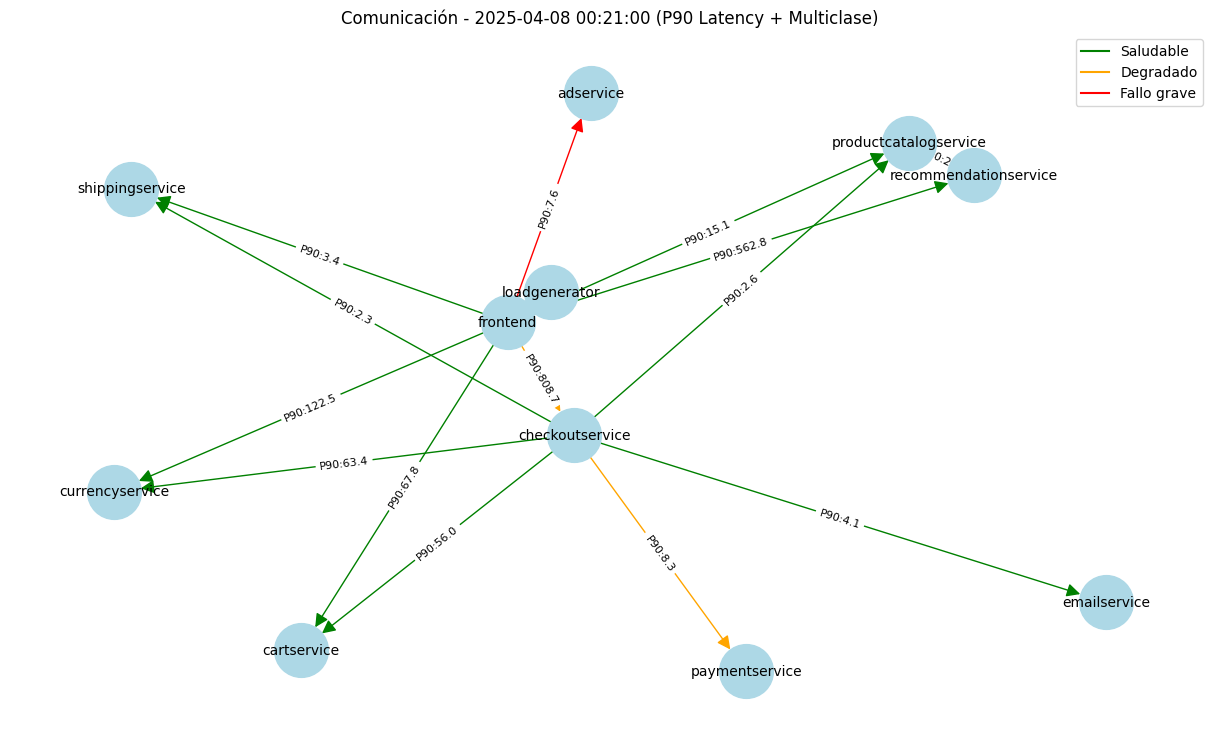

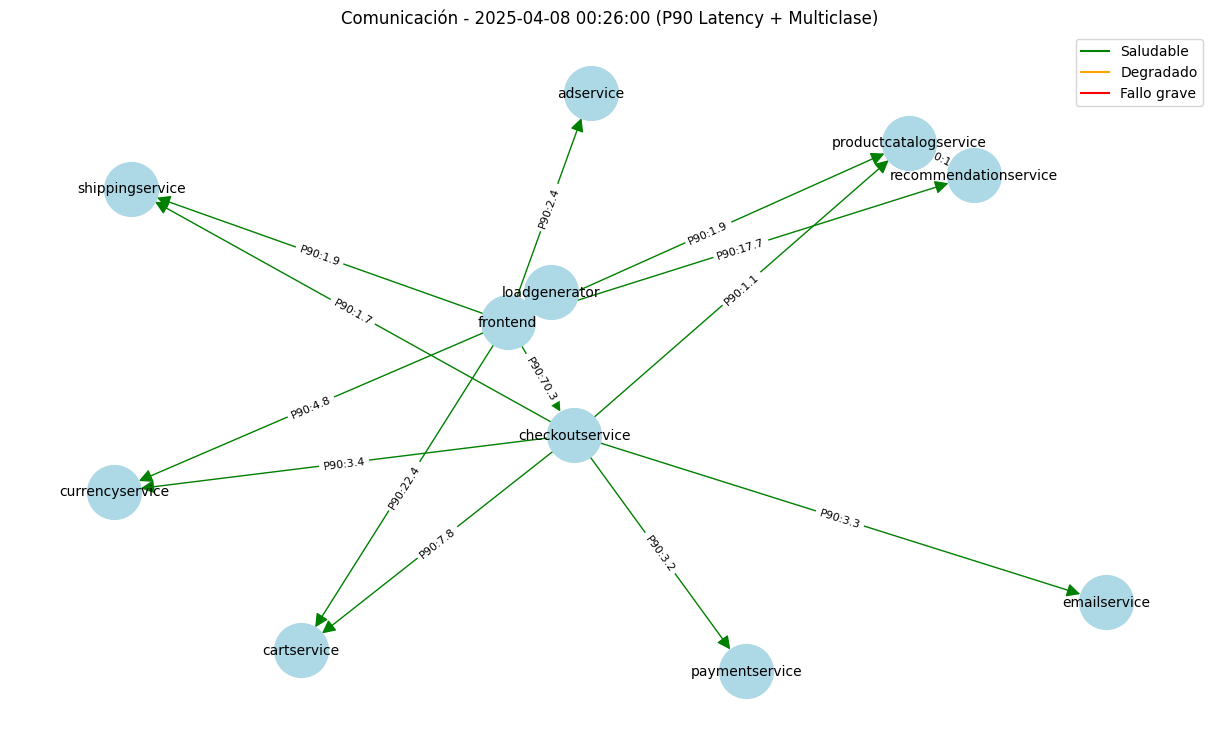

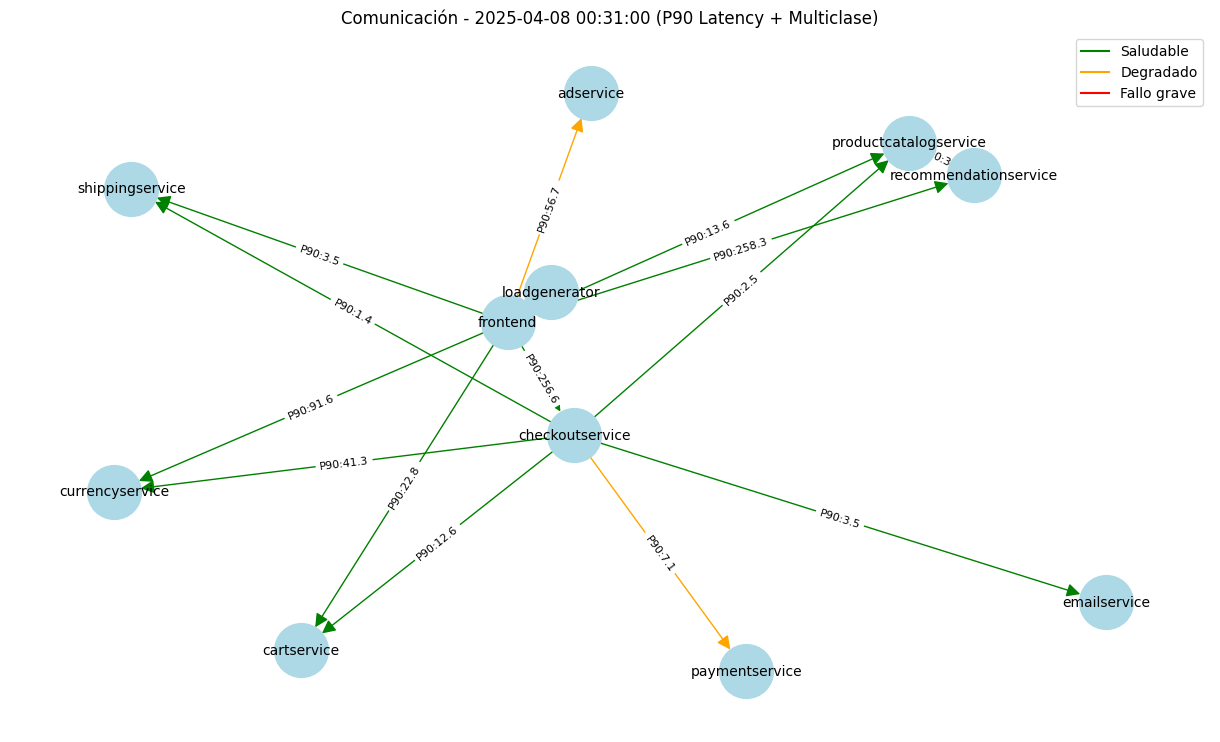

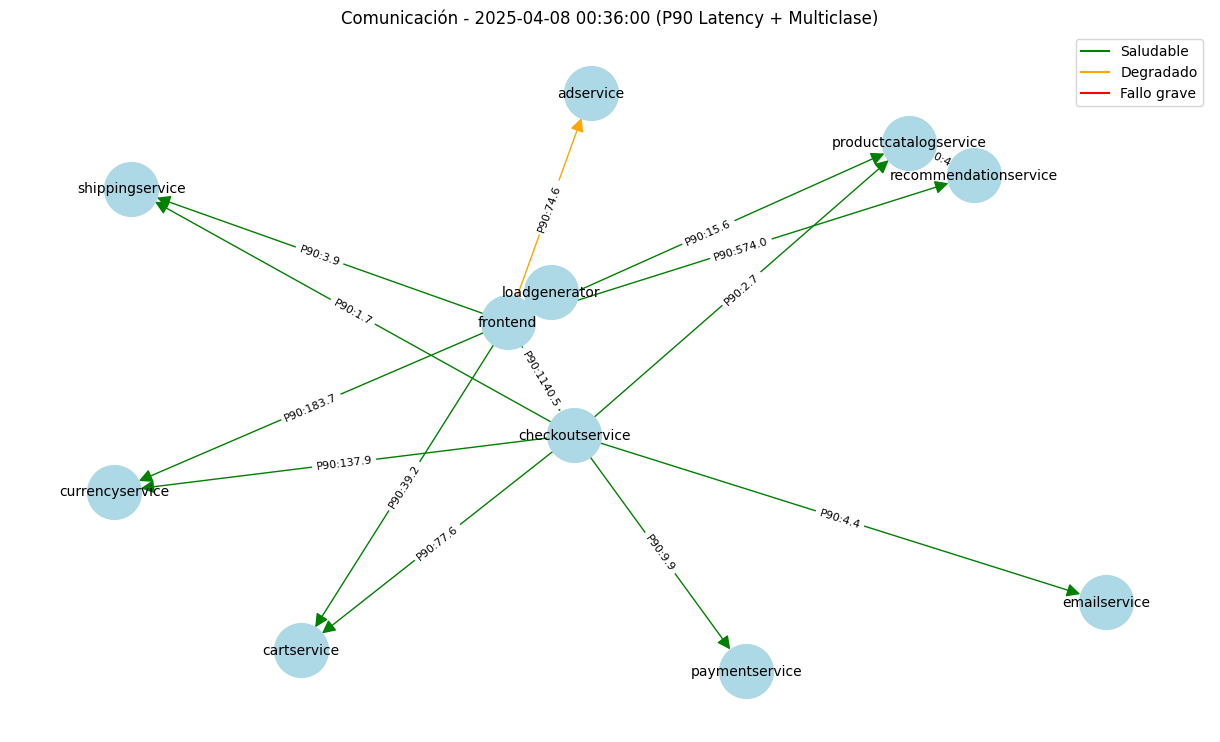

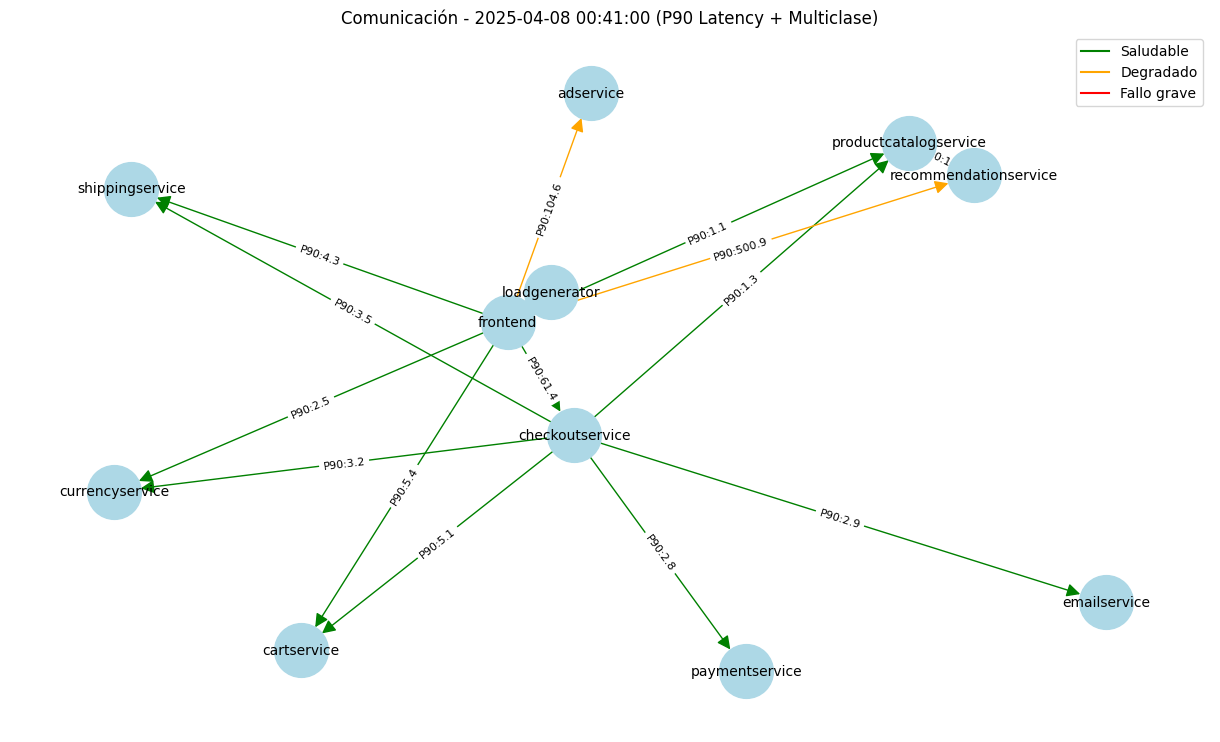

In [4]:
## p90 Latency Visualization
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# ⏱ Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Merge
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🏷 Etiquetado multiclase
def assign_status_multiclase(er):
    if er < 0.01:
        return 0  # Saludable
    elif er < 0.15:
        return 1  # Degradado
    else:
        return 2  # Fallo grave

df['status'] = df['error_rate_kpi'].apply(assign_status_multiclase)

# ✅ CAMBIA AQUÍ para mostrar P50, P90 o P99
percentil = "p90_latency"  # ← Cambia a "p50_latency" o "p99_latency" si lo deseas
label_tag = percentil.upper().replace("_LATENCY", "")

# 📆 Momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# Colores para las clases
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Fallo grave"}

# Visualización temporal
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   latency=row.get(percentil, None))

    edge_colors = [color_map.get(G[u][v]['status'], 'gray') for u, v in G.edges()]
    edge_labels = {
        (u, v): f"{label_tag}:{G[u][v]['latency']:.1f}"
        for u, v in G.edges() if G[u][v]['latency'] is not None
    }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color=edge_colors, node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    for cls, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[cls])
    plt.legend(loc="upper right")

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} ({label_tag} Latency + Multiclase)")
    plt.show()


✅ Resumen del flujo del notebook gnn_analysis_and_temporal_visualization.ipynb
Este notebook implementa un pipeline completo de análisis de fallos en sistemas de microservicios mediante grafos y aprendizaje automático:

🔹 1. Carga y preprocesamiento de datos
Se cargan dos conjuntos de datos:

Métricas de Kiali (kiali_kpi_metrics.csv)

Percentiles de latencia (kiali_latency_percentiles.csv)

Se filtran y limpian los datos según criterios de calidad y ventana temporal (15S).

Se redondean timestamps para alinear eventos por minuto.

🔹 2. Construcción de etiquetas multiclase
Se genera una columna status:

0 = saludable

1 = degradado

2 = fallo grave

Esta etiqueta se usa tanto para el análisis como para entrenar el modelo.

🔹 3. Modelo GNN para clasificación de enlaces
Se construye un grafo con PyTorch Geometric.

Se entrena un modelo GNN para predecir el estado de la comunicación entre microservicios.

Se evalúa el modelo con métricas como classification_report y F1-score.

🔹 4. Visualización temporal del grafo
Se construyen grafos dirigidos con NetworkX.

Cada 5 timestamps se visualiza el estado del sistema, coloreando aristas según el status y mostrando el percentil de latencia (P50, P90 o P99).

Permite interpretar visualmente degradaciones o cuellos de botella.

🧩 Uso propuesto
Este notebook sirve como herramienta de diagnóstico basada en datos históricos y análisis automático para identificar causas raíz de fallos.



In [5]:
import json

# Ruta al archivo JSON combinado
with open("combined_graph.json", "r", encoding="utf-8") as f:
    graph = json.load(f)

mutations = []

for obj in graph:
    if obj["dgraph.type"] == "Node":
        name = obj["node"]["name"]
        mutations.append(f'''
mutation {{
  addNode(input: {{
    name: "{name}"
  }}) {{
    node {{ name }}
  }}
}}
''')
    elif obj["dgraph.type"] == "Pod":
        pod = obj["pod"]
        node_name = obj["isDeployedOn"]["uid"].replace("_:node_", "").replace("_", " ")
        mutations.append(f'''
mutation {{
  addPod(input: {{
    name: "{pod["name"]}",
    timestamp: "{pod["timestamp"]}",
    microservice: "{pod["microservice"]}",
    abnormality: "{pod["abnormality"]}",
    experiment: {pod["experiment"]},
    cpu: {pod["cpu"]},
    memory: {pod["memory"]},
    net_rx: {pod["net_rx"]},
    net_tx: {pod["net_tx"]},
    isDeployedOn: {{
      name: "{node_name}"
    }}
  }}) {{
    pod {{ name }}
  }}
}}
''')
    elif obj["dgraph.type"] == "Microservice":
        name = obj["microservice"]["name"]
        mutations.append(f'''
mutation {{
  addMicroservice(input: {{
    name: "{name}"
  }}) {{
    microservice {{ name }}
  }}
}}
''')
    elif obj["dgraph.type"] == "Communication":
        from_name = obj["from"]["uid"].replace("_:ms_", "").replace("_", " ")
        to_name = obj["to"]["uid"].replace("_:ms_", "").replace("_", " ")
        comm = obj["communication"]
        mutations.append(f'''
mutation {{
  addCommunication(input: {{
    from: {{ name: "{from_name}" }},
    to: {{ name: "{to_name}" }},
    communication: {{
      timestamp: "{comm["timestamp"]}",
      throughput: {comm["throughput"]},
      duration_milliseconds: {comm["duration_milliseconds"]},
      request_rate: {comm["request_rate"]},
      istio_request_bytes: {comm["istio_request_bytes"]},
      average_latency: {comm["average_latency"]},
      new_request: {comm["new_request"]},
      status: {comm["status"]}
    }}
  }}) {{
    communication {{ communication {{ timestamp }} }}
  }}
}}
''')

# Guardar en archivo
with open("graphql_mutations.graphql", "w", encoding="utf-8") as f:
    f.writelines(mutations)

print("✅ Archivo 'graphql_mutations.graphql' generado correctamente.")


✅ Archivo 'graphql_mutations.graphql' generado correctamente.
